# EC Processing Functions
This notebook contains some work on figuring out implementations of common EC Processing functions. It's meant as a temporary workspace/testbed

In [1]:
from pathlib import Path
from datetime import datetime
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy import stats
from scipy import optimize
from scipy import signal
from statsmodels.tsa.stattools import acf

from tilt_corrections import *

In [2]:
# directories specific to Alex's computer
data_dir = Path('/Users/waldinian/Project_Data/Platinum_EC/BB-SF')
EC_4m_dir = data_dir / 'EC' / '4m' / 'Converted'
EC_7m_dir = data_dir /'EC' / '7m' / 'Converted'
Snow_dir = data_dir / 'Snow'
SoilHF_dir = data_dir / 'SoilHF'

In [3]:
def get_timestamp_from_fn(fn):
    '''
    Given a raw high-frequency data file, get the starting timestamp from the filename.
    filenames look like:
    ^.*10Hz[0-9]+_yyyy_mm_dd_hhMM$
    
    Parameters
    ----------
    fn: str or path
    
    Returns
    -------
    datetime.datetime
    '''
    # get a list of [yyyy, mm, dd, hh, MM] from filename
    timestamp_elements = fn.stem.split('10Hz')[1].split('_')[1:]
    hh, mm = timestamp_elements[-1][:2], timestamp_elements[-1][2:]
    timestamp_elements = timestamp_elements[:-1] + [hh, mm]
    timestamp_elements = [int(i) for i in timestamp_elements]
    # convert to datetime
    timestamp = datetime(*timestamp_elements)
    return timestamp

def read_campbell_file(fn, 
                       parse_dates=['TIMESTAMP'], skiprows=[0, 2, 3], na_values=['NAN', '"NAN"', "'NAN'"], 
                       **read_csv_kwargs):
    '''
    read in a campbell scientific TOA5/TOB3 file as a pandas dataframe.
    '''
    df = pd.read_csv(
        fn, 
        skiprows=skiprows, 
        parse_dates=parse_dates, 
        na_values=na_values,
        **read_csv_kwargs
                    )
    return df

def compute_summary(fn, renaming_dict, 
                    **read_campbell_file_kwargs):
    '''Compute statistical summary of a high-frequency data file
    
    Parameters
    ----------
    fn: str or path
        path to the desired file
    renaming_dict: dict
        a mapping from raw_column_name -> standardized_column_name. Only columns in the renaming_dict will be returned. Do not include the TIMESTAMP column
    **read_campbell_file_kwargs: dict
        keyword arguments passed to read_campbell_file()
    
    Returns
    -------
    df_out : pd.DataFrame
        a dataframe containing the specified columns (renaming_dict.values()) with statistical suffixes attached and relevant statistics computed.
    '''
    
    df = (
        read_campbell_file(fn)
        .rename(columns=renaming_dict)
    )
    
    new_names = renaming_dict.values()
    mean_colnames = [f'{k}_mean' for k in new_names]
    std_colnames = [f'{k}_std' for k in new_names]
    skw_colnames = [f'{k}_skw' for k in new_names]
    krt_colnames = [f'{k}_krt' for k in new_names]
    
    means = df[new_names].mean().rename({k:v for k, v in zip(new_names, mean_colnames)}).values
    stds = df[new_names].std().rename({k:v for k, v in zip(new_names, std_colnames)}).values
    skws = df[new_names].skew().rename({k:v for k, v in zip(new_names, skw_colnames)}).values
    krts = df[new_names].kurt().rename({k:v for k, v in zip(new_names, krt_colnames)}).values
    
    columns = mean_colnames + std_colnames + skw_colnames + krt_colnames
    data = np.concatenate([means, stds, skws, krts])[:, np.newaxis]
    
    df_out = pd.DataFrame({k:v for k, v in zip(columns, data)})
    
    return df_out

Our data is split up into a bunch of files. Here, I'm just looping through them.

Load some summary information on our data files into a dataframe indexed by file timestamp

Compute some summary data to add to the dataframe

In [6]:
# record file timestamps and paths
EC_7m_fast_fns = list(EC_7m_dir.glob('TOA5*10Hz*dat'))
EC_7m_df = pd.DataFrame(dict(fn=EC_7m_fast_fns))
EC_7m_df['TIMESTAMP'] = list(map(get_timestamp_from_fn, EC_7m_df['fn']))
EC_7m_df = EC_7m_df.sort_values('TIMESTAMP').set_index('TIMESTAMP')
EC_7m_df.head()

# compute summary statistics by looping through data files
renaming_dict=dict(
    Ux_CSAT3B='U',
    Uy_CSAT3B='V',
    Uz_CSAT3B='W',
    Ts_CSAT3B='Ts',
    rho_c_LI7500='rhoCO2',
    rho_v_LI7500='rhoH2O',
    P_LI7500='P'
)
summary_data = pd.concat([compute_summary(fn, renaming_dict) for fn in tqdm(EC_7m_df['fn'])])
summary_data = summary_data.set_index(EC_7m_df.index)
EC_7m_df = EC_7m_df.merge(summary_data, left_index=True, right_index=True)

100%|███████████████████████████████████████████████████| 671/671 [00:29<00:00, 22.60it/s]


# Tilt Corrections
## Double rotation method (Wilczak et al, 2001)
Align $\hat i$ with the mean windspeed for each block. Do this by first rotating in azimuth ($\theta$) then in elevation ($\phi$). This method does not attempt to learn anything about the surrounding topography/streamline landscape, and instead naively aligns its coordinate system with the current windspeed.

## Planar fit method (Wilczak et al, 2001)
Align $\hat i$ for each block with the mean windspeed over all blocks. Then for each block, rotate in azimuth ($\theta$) to align the mean windspeed with $\hat i$ in the $uv$-plane. This approximates the surrounding topography/streamlines as an infinite plane with some orientation, and tries to match the instrument coordinates to the orientation of that plane.

## Continuous planar fit method (Ross et al 2015)
Perfrom the DR method using a fourier series approximation for $\phi \sim \mathcal F (\theta)$ of order $N$, computed across all blocks. When $N$ is maximized, this is analagous to the DR method. When $N=1$, this is analagous to the standard planar fit method. This method assumes approximates the surrounding topography/streamlines with a smooth periodic function, and tries to match the instrument coordinates to reflect that (with some predetermined resolution). This is nice because it doesn't suffer from underfitting like the Planar Fit method, but remains infinitely differentiable making it nice for further analysis.

In [9]:
EC_7m_df_rot = EC_7m_df.copy()

Demonstration of various tilt correction algorithms

In [15]:
# generate some continuous data to plot against
theta_sim = np.linspace(0, 2*np.pi, 1001)

# compute angles using the double-rotation algorithm
theta, phi_DRF = get_double_rotation_angles(EC_7m_df['U_mean'], EC_7m_df['V_mean'], EC_7m_df['W_mean'])

# we'll loop through 100 iterations of each fit using a different set of training data each time
# to get some sense of uncertainty
n = 500
phi_sim_2CPF = np.empty((theta_sim.size, n))
phi_sim_15CPF = np.empty((theta_sim.size, n))
phi_sim_SPF = np.empty((theta_sim.size, n))
train_n = int(theta.size*0.7)
for i in tqdm(range(n)):
    # get some random theta angles to train on
    idx = np.random.choice(np.arange(theta.size), size=train_n, replace=False)
    # 4th order continuous planar fit
    phi_approx_15CPF, _ = get_continuous_planar_fit_angles(theta[idx], phi_DRF[idx], 4)
    phi_sim_15CPF[:, i] = phi_approx_15CPF(theta_sim)
    # 2nd order continuous planar fit
    phi_approx_2CPF, _ = get_continuous_planar_fit_angles(theta[idx], phi_DRF[idx], 2)
    phi_sim_2CPF[:, i] = phi_approx_2CPF(theta_sim)
    # 1st order continuous planar fit
    phi_approx_SPF, _ = get_continuous_planar_fit_angles(theta[idx], phi_DRF[idx], 1)
    phi_sim_SPF[:, i] = phi_approx_SPF(theta_sim)
    
# convert rad->deg
theta_sim = theta_sim*180/np.pi
theta = theta*180/np.pi
phi_DRF = phi_DRF*180/np.pi
phi_sim_15CPF = phi_sim_15CPF*180/np.pi
phi_sim_2CPF = phi_sim_2CPF*180/np.pi
phi_sim_SPF = phi_sim_SPF*180/np.pi

100%|███████████████████████████████████████████████████| 500/500 [00:30<00:00, 16.36it/s]


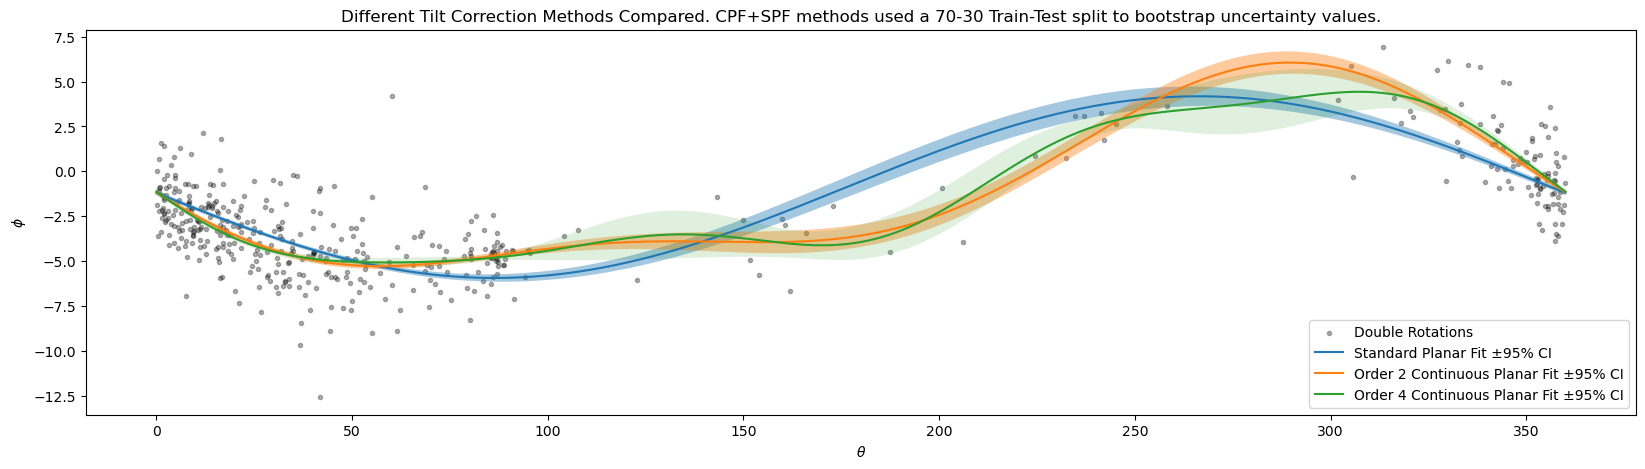

In [16]:
fig = plt.figure(figsize=(20,5))
plt.scatter(theta[idx], phi_DRF[idx], s=3**2, c='k', label='Double Rotations', alpha=0.3)
plt.plot(theta_sim, phi_sim_SPF.mean(1), label='Standard Planar Fit ±95% CI')
plt.fill_between(theta_sim, phi_sim_SPF.mean(1) - phi_sim_SPF.std(1)*1.96, phi_sim_SPF.mean(1) + phi_sim_SPF.std(1)*1.96, alpha=0.4)
plt.plot(theta_sim, phi_sim_2CPF.mean(1), label='Order 2 Continuous Planar Fit ±95% CI')
plt.fill_between(theta_sim, phi_sim_2CPF.mean(1) - phi_sim_2CPF.std(1)*1.96, phi_sim_2CPF.mean(1) + phi_sim_2CPF.std(1)*1.96, alpha=0.4)
plt.plot(theta_sim, phi_sim_15CPF.mean(1), label='Order 4 Continuous Planar Fit ±95% CI')
plt.fill_between(theta_sim, phi_sim_15CPF.mean(1) - phi_sim_15CPF.std(1)*1.96, phi_sim_15CPF.mean(1) + phi_sim_15CPF.std(1)*1.96, alpha=0.15)

plt.xlabel('$\\theta$')
plt.ylabel('$\\phi$')
# plt.ylim(phi_DRF.min() - 5, phi_DRF.max() + 5)
plt.title('Different Tilt Correction Methods Compared. CPF+SPF methods used a 70-30 Train-Test split to bootstrap uncertainty values.')
plt.legend();

In [12]:
EC_7m_df_rot[['U_mean_CPF', 'V_mean_CPF', 'W_mean_CPF']] = continuous_planar_fit_from_uvw(EC_7m_df['U_mean'], EC_7m_df['V_mean'], EC_7m_df['W_mean'], 2)
EC_7m_df_rot[['U_mean_SPF', 'V_mean_SPF', 'W_mean_SPF']] = continuous_planar_fit_from_uvw(EC_7m_df['U_mean'], EC_7m_df['V_mean'], EC_7m_df['W_mean'], 1)
EC_7m_df_rot[['U_mean_DRF', 'V_mean_DRF', 'W_mean_DRF']] = double_rotation_fit_from_uvw(EC_7m_df['U_mean'], EC_7m_df['V_mean'], EC_7m_df['W_mean'])

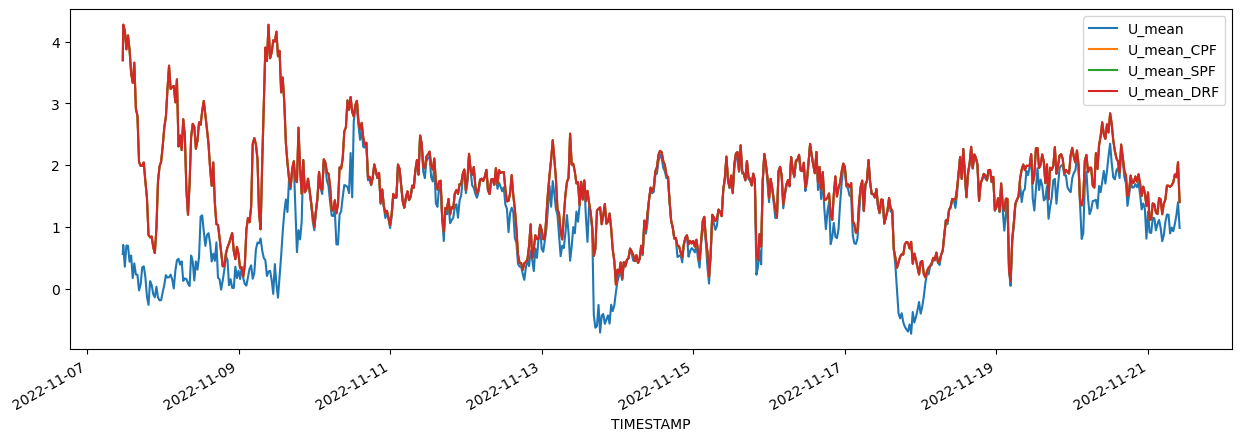

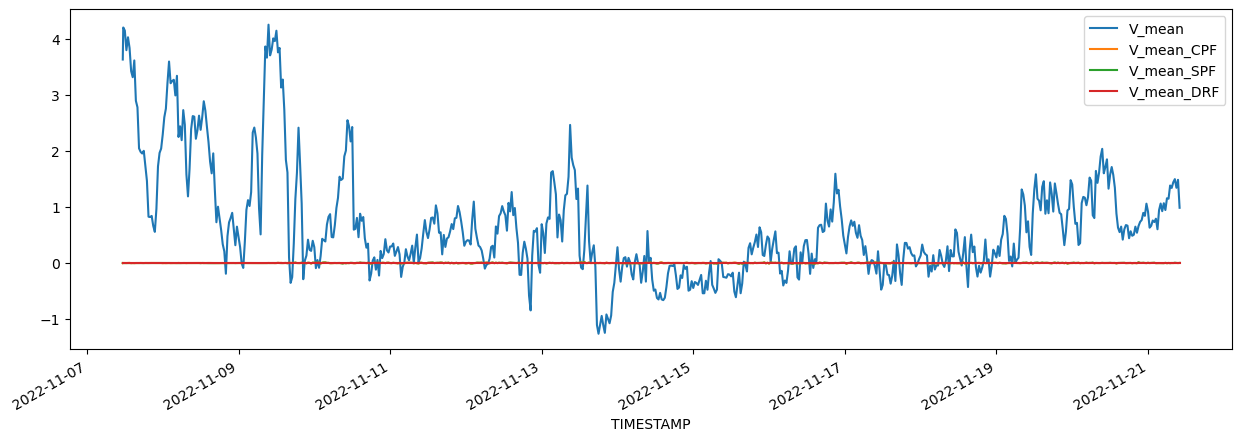

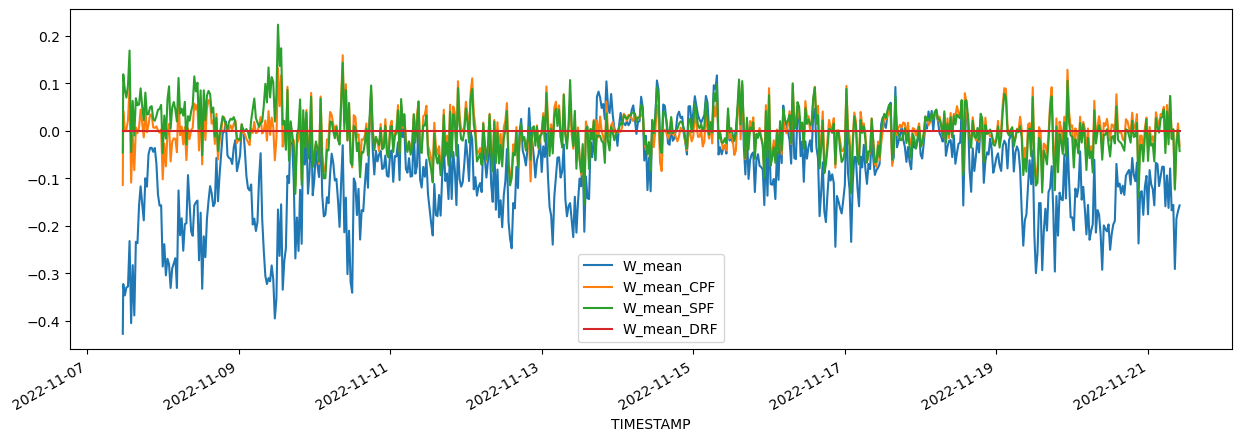

In [13]:
EC_7m_df_rot[['U_mean', 'U_mean_CPF', 'U_mean_SPF', 'U_mean_DRF']].plot(figsize=(15,5))
EC_7m_df_rot[['V_mean', 'V_mean_CPF', 'V_mean_SPF', 'V_mean_DRF']].plot(figsize=(15,5))
EC_7m_df_rot[['W_mean', 'W_mean_CPF', 'W_mean_SPF', 'W_mean_DRF']].plot(figsize=(15,5));
